In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Chemin vers ton zip
zip_path = "/content/drive/MyDrive/datasets/GTSRB.zip"

# Dossier où extraire
extract_path = "/content/drive/MyDrive/datasets/GTSRB1"

# Décompression
!unzip -q "$zip_path" -d "$extract_path"

# Vérification
print("Dossiers extraits :", os.listdir(extract_path)[:5])


Dossiers extraits : ['Meta.csv', 'Meta', 'Test.csv', 'Test', 'Train.csv']


In [ ]:
# STEP 1: Import Libraries
# ==============================
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [ ]:
 # STEP 2: Load CSVs
# ==============================
train_csv = pd.read_csv("/content/drive/MyDrive/datasets/GTSRB1/Train.csv")
test_csv  = pd.read_csv("/content/drive/MyDrive/datasets/GTSRB1/Test.csv")

print(f"Training samples: {len(train_csv)}, Test samples: {len(test_csv)}")

Training samples: 39209, Test samples: 12630


In [ ]:
# STEP 3: Load Images
# ==============================
IMG_SIZE = 32

# Function to load images into arrays
def load_images_from_dataframe(df, base_path):
    images = []
    labels = []
    for _, row in df.iterrows():
        # Correctly construct the image path
        img_path = f"{base_path}/{row['Path']}"
        img = cv2.imread(img_path)
        # Check if image is loaded successfully
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(row['ClassId'])
        else:
            print(f"Warning: Could not load image {img_path}")
    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_dataframe(train_csv, "/content/drive/MyDrive/datasets/GTSRB1")
X_test, y_test   = load_images_from_dataframe(test_csv,  "/content/drive/MyDrive/datasets/GTSRB1")

# Normalize
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)

num_classes = y_train.shape[1]
print(f"Number of classes: {num_classes}")

Number of classes: 43


In [ ]:
# STEP 4: Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [ ]:
# STEP 5: Data Augmentation
# ==============================
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator()

In [ ]:
# STEP 6: Build CNN Model
# ==============================
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# STEP 7: Train Model with Augmentation
# ==============================
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=64),
    validation_data=val_datagen.flow(X_val, y_val, batch_size=64),
    epochs=15
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9469 - loss: 0.1734 - val_accuracy: 0.9878 - val_loss: 0.0438
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9517 - loss: 0.1579 - val_accuracy: 0.9878 - val_loss: 0.0420
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9537 - loss: 0.1544 - val_accuracy: 0.9878 - val_loss: 0.0409
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9629 - loss: 0.1196 - val_accuracy: 0.9908 - val_loss: 0.0336
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9634 - loss: 0.1195 - val_accuracy: 0.9883 - val_loss: 0.0395
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9644 - loss: 0.1174 - val_accuracy: 0.9922 - val_loss: 0.0272
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9681 - loss: 0.1099 - val_accuracy: 0.9921 - val_loss: 0.0276
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.9727 - loss: 0.0927 - val_accurac

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9618 - loss: 0.1958

Test Accuracy: 0.9606
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


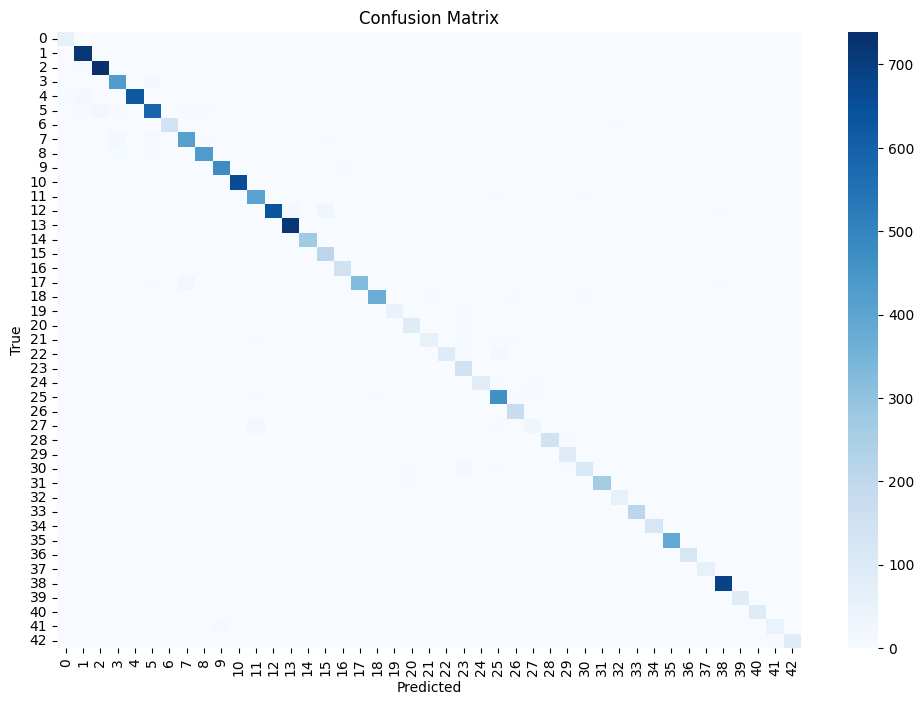


Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94        60
           1       0.96      1.00      0.98       720
           2       0.97      0.99      0.98       750
           3       0.93      0.95      0.94       450
           4       1.00      0.95      0.97       660
           5       0.93      0.93      0.93       630
           6       0.99      0.93      0.96       150
           7       0.94      0.92      0.93       450
           8       0.98      0.96      0.97       450
           9       0.98      0.99      0.98       480
          10       0.99      1.00      1.00       660
          11       0.92      0.97      0.95       420
          12       1.00      0.92      0.96       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.87      1.00      0.93       210
          16       0.97      1.00      0.99       150
   

In [ ]:
# STEP 8: Evaluate Model
# ==============================
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

In [ ]:
# STEP 9: Save Model
# ==============================
model.save("gtsrb_cnn_augmented_csv.h5")
print("Model saved as gtsrb_cnn_augmented_csv.h5")

Model saved as gtsrb_cnn_augmented_csv.h5


=== Vérification TRAIN ===
Annotations sans image : 21167
Images sans annotation : 0
21167 annotations supprimées du CSV.
0 images sans annotation supprimées du dossier.
